#Load from ZIP file#

In [0]:
# !unzip dummy_Inria_data.zip

#Define Training Path#

In [0]:
# TRAIN_PATH = '/content/gdrive/My Drive/thesis_data/inria_dataset_256/train/'
TRAIN_PATH = 'dummy_Inria_data/train/'

#FCN#

In [0]:
import os
import sys
import cv2
import time
import random
import keras
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras import backend as keras
from skimage.transform import resize
from keras.utils import plot_model, Sequence
import keras.backend.tensorflow_backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.layers import Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate
from skimage.transform import resize, rotate, rescale, warp, AffineTransform

from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add

In [0]:
class DataAugmentation():
    """ Class for data augmentation.

        Mainly helps when the training data is small

        Parameters: image, mask,
                    rotation angle (default = 90)
                    zoom_range (default = 1)
                    horizontal_flip (default = False)
                    vertical_flip (default = False)
                    activate (default = False)
    """

    def __init__(self, image, mask,
                rotation = 0,
                zoom_range = 1,
                horizontal_flip = False,
                vertical_flip = False,
                shear = 0,
                activate = False):

        self.image = image
        self.mask = mask
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear
        self.activate = activate

    def rotate_data(self):
        """ Rotation
        """
        self.image = rotate(self.image, self.rotation)
        self.mask = rotate(self.mask, self.rotation)
        return self.image, self.mask

    def rescale_data(self):
        """ Rescaling
        """
        height, width, _ = self.image.shape
        self.image = rescale(self.image, self.zoom_range)
        self.image = resize(self.image, (height, width))

        self.mask = rescale(self.mask, self.zoom_range)
        self.mask = resize(self.mask, (height, width))
        return self.image, self.mask

    def flip_horizontal_data(self):
        """ Flip Horizontally
        """
        if self.horizontal_flip == True:
            flipped_image = np.flip(self.image, 1)
            flipped_mask = np.flip(self.mask, 1)
            return flipped_image, flipped_mask

    def flip_vertically_data(self):
        """ Flip Vertically
        """
        if self.vertical_flip == True:
            flipped_image = np.flip(self.image, 0)
            flipped_mask = np.flip(self.mask, 0)
            return flipped_image, flipped_mask

    def shear_data(self):
        """ Shear
        """
        trans = AffineTransform(shear = 0.2)
        self.image = warp(self.image, inverse_map= trans)
        self.mask = warp(self.mask, inverse_map= trans)
        return self.image, self.mask

    def augment(self):
        if self.activate == True:
            images = []
            masks = []
            images.append(self.image)
            masks.append(self.mask)
            # print('Augmentation:: Image List Size: ',len(images))
            if self.rotation != 0:
                self.image, self.mask = self.rotate_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.zoom_range != 1:
                self.image, self.mask = self.rescale_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.horizontal_flip == True:
                self.image, self.mask = self.flip_horizontal_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.vertical_flip == True:
                self.image, self.mask = self.flip_vertically_data()
                images.append(self.image)
                masks.append(self.mask)

            if self.shear != 0:
                self.image, self.mask = self.shear_data()
                images.append(self.image)
                masks.append(self.mask)
        else:
            images = []
            masks = []
            images.append(self.image)
            masks.append(self.mask)

        images = np.array(images)
        masks = np.array(masks)

        return images, masks

In [0]:
from keras.utils import Sequence
class InriaDataLoader(Sequence):
    """ Load the training dataset for Inria Dataset from the
        data folder and put in an array

        Parameters: - data_path: Loads the datapath
                    - patch_size: Format the image sizes (default: 256x256)
                    - train_ids:

    """
    def __init__(self, data_ids, data_path, patch_size = 256,
                batch_size = 8, aug = False, rotation = 0,
                zoom_range = 1, horizontal_flip = False,
                vertical_flip = False, shear = 0):

        self.data_path = data_path
        self.data_ids = data_ids
        self.patch_size = patch_size
        self.batch_size = batch_size
        self.aug = aug
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear

    def __load__(self, data_name):
        """ Load an image and a mask from the data folder
            Parameters: Image name
        """
        image_name_path = os.path.join(self.data_path,'images/', data_name)
        mask_name_path = os.path.join(self.data_path, 'gt', data_name)

        image = cv2.imread(image_name_path, 1)
        image = cv2.resize(image, (self.patch_size,
                            self.patch_size))

        mask = cv2.imread(mask_name_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (self.patch_size,
                            self.patch_size))
        mask = mask[:, :, np.newaxis]

        image = image/255.
        
        mask = mask/255.

        return image, mask

    def __getitem__(self, index):
        """ Get all the images and masks in the data folder
            and put into array
        """
        if(index+1)*self.batch_size > len(self.data_ids):
            self.batch_size = len(self.data_ids) - index*self.batch_size

        files_batch = self.data_ids[index * \
            self.batch_size: (index + 1) * self.batch_size]

        images = []
        masks = []

        for file in files_batch:
            image, mask = self.__load__(file)
    
            aug = DataAugmentation(image, mask,
                                   rotation =self.rotation,
                                   zoom_range = self.zoom_range,
                                   horizontal_flip = self.horizontal_flip,
                                   vertical_flip = self.vertical_flip,
                                   activate = self.aug)

            aug_images, aug_masks = aug.augment()

            for aug_image in aug_images:
                images.append(aug_image)

            for aug_mask in aug_masks:
                masks.append(aug_mask)
              

        images = np.array(images)
        masks = np.array(masks)

        return images, masks


    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.data_ids)/float(self.batch_size)))

In [0]:
class Visualizer():
    """ Class for visualizing input image and corresponding
        mask

        Parameters: image
                    mask
    """
    def __init__(self, image, mask, image_size = 256):
        self.image = image
        self.mask = mask
        self.image_size = image_size

    def plot(self):
        fig = plt.figure()
        fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

        fig_a = fig.add_subplot(1, 2, 1)
        fig_a.set_title('Input Image')
        image = np.reshape(self.image[0]*255, 
                           (self.image_size, self.image_size))
        plt.imshow(image)

        fig_b = fig.add_subplot(1, 2, 2)
        fig_b.set_title('Output Mask')
        mask = np.reshape(self.mask[0]*255, 
                          (self.image_size, self.image_size))
        plt.imshow(mask)

        plt.show()

In [0]:

from keras.models import Model
from keras.layers import Input
from keras.layers.core import Lambda, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf


# def dice_coef(y_true, y_pred):
#     return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)
class FCN():
    '''
    '''
    def __init__(self,num_classes = 1, input_shape = (256,256,3), lr_init = 0.0001, lr_decay=0.0005):
        self.num_classes = num_classes
        self.input_shape = input_shape
        self.lr_init = lr_init
        self.lr_decay = lr_decay
#         self.vgg_weight_path = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
        self.vgg_weight_path = None
    
    def Convblock(self,channel_dimension, block_no, no_of_convs) :
      Layers = []
      for i in range(no_of_convs) :

          Conv_name = "conv"+str(block_no)+"_"+str(i+1)

          # A constant kernel size of 3*3 is used for all convolutions
          Layers.append(Convolution2D(channel_dimension,kernel_size = (3,3),padding = "same",activation = "relu",name = Conv_name))

      Max_pooling_name = "pool"+str(block_no)

      #Addding max pooling layer
      Layers.append(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name = Max_pooling_name))

      return Layers
  
    def FCN_8_helper(self,image_size=256):
      model = Sequential()
      model.add(Permute((1,2,3),input_shape = (image_size,image_size,3)))

      for l in self.Convblock(64,1,2) :
          model.add(l)

      for l in self.Convblock(128,2,2):
          model.add(l)

      for l in self.Convblock(256,3,3):
          model.add(l)

      for l in self.Convblock(512,4,3):
          model.add(l)

      for l in self.Convblock(512,5,3):
          model.add(l)

      model.add(Convolution2D(4096,kernel_size=(7,7),padding = "same",activation = "relu",name = "fc6"))

      #Replacing fully connnected layers of VGG Net using convolutions
      model.add(Convolution2D(4096,kernel_size=(1,1),padding = "same",activation = "relu",name = "fc7"))

      # Gives the classifications scores for each of the 21 classes including background
      model.add(Convolution2D(21,kernel_size=(1,1),padding="same",activation="relu",name = "score_fr"))

      Conv_size = model.layers[-1].output_shape[2] #16 if image size if 512
      #print(Conv_size)

      model.add(Deconvolution2D(21,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2"))

      # O = ((I-K+2*P)/Stride)+1 
      # O = Output dimesnion after convolution
      # I = Input dimnesion
      # K = kernel Size
      # P = Padding

      # I = (O-1)*Stride + K 
      Deconv_size = model.layers[-1].output_shape[2] #34 if image size is 512*512

      #print(Deconv_size)
      # 2 if image size is 512*512
      Extra = (Deconv_size - 2*Conv_size)

      #print(Extra)

      #Cropping to get correct size
      model.add(Cropping2D(cropping=((0,Extra),(0,Extra))))

      return model
    
    def network(self):
      fcn_8 = self.FCN_8_helper(256)
      #Calculating conv size after the sequential block
      #32 if image size is 512*512
      Conv_size = fcn_8.layers[-1].output_shape[2] 

      #Conv to be applied on Pool4
      skip_con1 = Convolution2D(1,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool4")

      #Addig skip connection which takes adds the output of Max pooling layer 4 to current layer
      Summed = add(inputs = [skip_con1(fcn_8.layers[14].output),fcn_8.layers[-1].output])

      #Upsampling output of first skip connection
      x = Deconvolution2D(1,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score4")(Summed)
      x = Cropping2D(cropping=((0,2),(0,2)))(x)


      #Conv to be applied to pool3
      skip_con2 = Convolution2D(1,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool3")

      #Adding skip connection which takes output og Max pooling layer 3 to current layer
      Summed = add(inputs = [skip_con2(fcn_8.layers[10].output),x])

      #Final Up convolution which restores the original image size
      Up = Deconvolution2D(1,kernel_size=(16,16),strides = (8,8),
                           padding = "valid",activation = None,name = "upsample")(Summed)

      #Cropping the extra part obtained due to transpose convolution
      final = Cropping2D(cropping = ((0,8),(0,8)))(Up)


      return Model(fcn_8.input, final)


In [0]:
# """
# Name: Train U-Net Model
# Author: Arghadeep Mazumder
# Version: 0.1
# Description: Train U-Net Model

# """
# import os
# import sys
# import cv2
# import keras.utils
# import numpy as np
# sys.path.append('../')
# from utils.iou import IoU
# from models.fcn import FCN
# from utils.loader import InriaDataLoader
# from keras.models import Model
# from keras.layers import *
# from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
# from utils.visualizer import InriaVisualizer

class TrainFCN():
    """ Class for training U-Net Model

        Parameters: train_path       = train folder
                    patch_size      = 256
                    activate_aug    = False
                    rotation        = 0
                    zoom_range      = 1
                    horizontal_flip = False
                    vertical_flip   = False
                    shear           = 0
                    net             = U-Net
                    epochs          = 5
                    batch_size      = 1
                    learning_rate   = 0.2
                    val_percent     =
                    save_model      = False
                    activate_gpu    = False
    """
    def __init__(self,
                train_path,
                image_size = 256,
                activate_aug = False,
                rotation = 0,
                zoom_range = 1,
                horizontal_flip = False,
                vertical_flip = False,
                shear = 0,
                epochs = 10,
                batch_size = 8,
                learning_rate = 0.1,
                save_model = True,
                val_data_size = 10,
                evaluate = True):

        self.train_path = train_path
        self.image_size = image_size
        self.activate_aug = activate_aug
        self.rotation = rotation
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.shear = shear
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.save_model = save_model
        self.val_data_size = val_data_size
        self.evaluate = evaluate

    def train(self):
        print('''
Start Training:

    Data Path:       {}
    Model:           {}
    Patch Size:      {}
    Augmentation:    {}
    Rotation:        {}
    Zoom Range:      {}
    Horizontal Flip: {}
    Vertical Flip:   {}
    Shear:           {}
    Epochs:          {}
    Batch Size:      {}
    Learning Rate:   {}
    Validation %:    {}
    Save Model:      {}
    Evaluate:        {}

        '''.format(str(self.train_path), str('U-Net'), self.image_size,
            self.activate_aug, self.rotation, self.zoom_range,
            self.horizontal_flip, self.vertical_flip, self.shear,
            self.epochs, self.batch_size, self.learning_rate,
            self.val_data_size, self.save_model, self.evaluate))

        images_path = os.path.join(self.train_path, 'images/')
        train_ids = next(os.walk(images_path))[2]

        valid_ids = train_ids[:self.val_data_size]
        train_ids = train_ids[self.val_data_size:]


        models = FCN()
        model = models.network()
        model.compile(optimizer = 'adam',
                    loss = 'binary_crossentropy',
                    metrics = ['acc'])
        model.summary()

        train_gen = InriaDataLoader(train_ids,
                                    self.train_path,
                                    patch_size = self.image_size,
                                    batch_size = self.batch_size)

        valid_gen = InriaDataLoader(valid_ids,
                                    self.train_path,
                                    patch_size = self.image_size,
                                    batch_size = self.batch_size)

        train_steps = len(train_ids) // self.batch_size
        valid_steps = len(valid_ids) // self.batch_size
        print(train_steps)
        model.fit_generator(train_gen,
                            validation_data = valid_gen,
                            steps_per_epoch = train_steps,
                            validation_steps = valid_steps,
                            epochs = self.epochs)
        if self.save_model:
            model.save('building_unet.h5')

#         keras.utils.plot_model(model, to_file = 'unet_architecture.png')

        if self.evaluate:
            image , mask = valid_gen.__getitem__(2)
            result = model.predict(image)
            result = result > 0.5
            viz = Visualizer(mask, result)
            viz.plot()

#         iou_score = IoU(target= mask, prediction=result)
#         print('IoU Score: ',iou_score)



Start Training:

    Data Path:       dummy_Inria_data/train
    Model:           U-Net
    Patch Size:      256
    Augmentation:    False
    Rotation:        0
    Zoom Range:      1
    Horizontal Flip: False
    Vertical Flip:   False
    Shear:           0
    Epochs:          10
    Batch Size:      8
    Learning Rate:   0.1
    Validation %:    10
    Save Model:      True
    Evaluate:        True

        
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
permute_3_input (InputLayer)    (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
permute_3 (Permute)             (None, 256, 256, 3)  0           permute_3_input[0][0]            
___________________________________________________________________________________

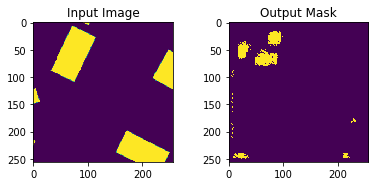

In [19]:
train_fcn = TrainFCN(train_path='dummy_Inria_data/train')
train_fcn.train()